**MLP классификатор (Keras Sequential model)** 

Евгений Борисов  <esborisov@sevsu.ru>

О методах обучения многослойных нейронных сетей прямого распространения.    
http://mechanoid.su/neural-net-backprop.html  
http://mechanoid.su/neural-net-backprop2.html

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=2)

## генерируем данные

In [3]:
n_samples = 1500

# from sklearn.datasets import make_blobs
# X,target = make_blobs( n_samples=n_samples, centers=2,  cluster_std=[1.5, 1.8,] )

# from sklearn.datasets import make_moons
# X,target = make_moons(n_samples=n_samples, noise=.09)

from sklearn.datasets import make_circles
X,target = make_circles(n_samples=n_samples, shuffle=True, noise=.09, factor=.3)
# X = X+(np.random.rand(X.shape[0],X.shape[1])*0.6)


y = np.eye(2)[target] 

X.shape, y.shape

((1500, 2), (1500, 2))

In [4]:
# нормируем данные
# from sklearn.preprocessing import MinMaxScaler
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

# from sklearn.preprocessing   import StandardScaler
# X = StandardScaler().fit(X).transform(X)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((750, 2), (750, 2), (750, 2), (750, 2))

In [6]:
del X
del y
del target

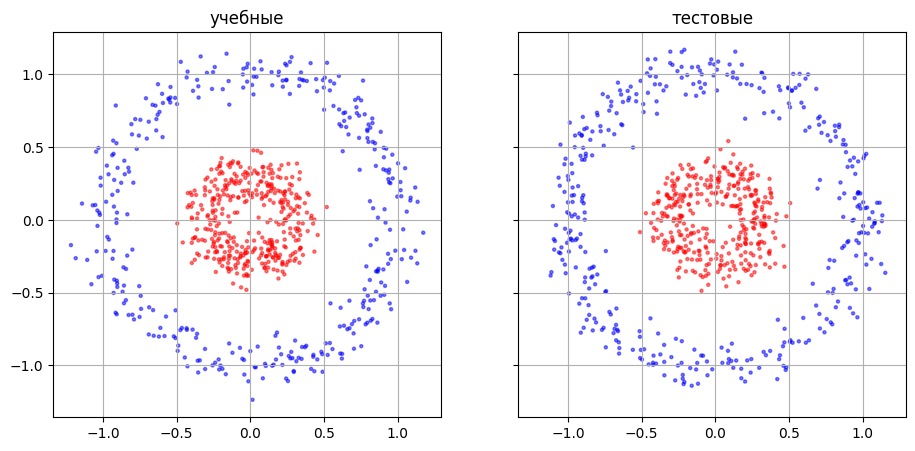

In [7]:
label2color = lambda l: np.array(['b','r','g','y'])[ l ]
out2color = lambda y: label2color( np.argmax(y,axis=1) )

fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(11,5),)

ax0.set_title('учебные')
ax0.scatter( x=X_train[:,0], y=X_train[:,1], c=out2color(y_train), s=5, alpha=0.5 )
ax0.grid()

ax1.set_title('тестовые')
ax1.scatter( x=X_test[:,0], y=X_test[:,1], c=out2color(y_test), s=5, alpha=0.5 )
ax1.grid()
  
plt.show()

## модель

схема нейрона

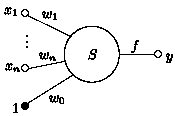

схема MPL 

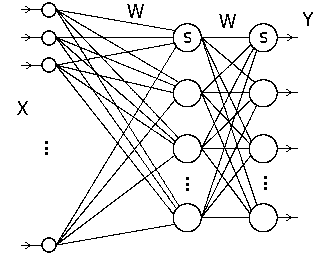

In [9]:
import tensorflow as tf
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Input 
from tensorflow.keras.activations import sigmoid

2023-04-10 09:32:21.209639: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 09:32:21.241747: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 09:32:21.242151: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 09:32:21.789042: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
model = Sequential([
    Input(X_train.shape[1]), # нулевой - распределительный/входной слой
    Dense(units=10,activation=sigmoid), # первый - обрабатывающий/скрытый слой
    Dense(units=5,activation=sigmoid), # второй - обрабатывающий/скрытый слой
    Dense(units=y_train.shape[1],activation=sigmoid) # третий - обрабатывающий/выходной слой
])

2023-04-10 09:32:22.471789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-10 09:32:22.486107: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## обучаем модель

функция потери средняя квадратичная ошибка
$$L=MSQE(y,o)=\frac{1}{m}\sum\limits_{i=0}^m(o_i-y_i)^2$$

In [11]:
from tensorflow.keras.callbacks import Callback

class AccuracyCallback(Callback): 
    
    def on_epoch_end(self, epoch, logs={}): 
        min_acc=.98
        acc = logs.get('accuracy')
        if acc is not None:
            if(logs.get('accuracy') > min_acc):   
                print('\naccuracy threshold reached\n')
                self.model.stop_training = True
        

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=.1)
loss = tf.keras.losses.MeanSquaredError()

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [13]:
from tensorflow.python.client import device_lib

devices = [ d.name for d in device_lib.list_local_devices()
           if d.device_type=='GPU' ]
device = devices[0] if len(devices)>0 else 'cpu'
display(device)

2023-04-10 09:32:30.055580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-10 09:32:30.055737: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'cpu'

In [14]:
%%time

result = model.fit(
    tf.cast(X_train,tf.float32),
    tf.cast(y_train,tf.float32),
    batch_size=len(y_train)//3, 
    epochs=135,
    callbacks=[AccuracyCallback()],
)    

Epoch 1/135
3/3 [==============================] - 0s 3ms/step - loss: 0.2582 - accuracy: 0.5067
Epoch 2/135
3/3 [==============================] - 0s 2ms/step - loss: 0.2577 - accuracy: 0.5227
Epoch 3/135
3/3 [==============================] - 0s 2ms/step - loss: 0.2512 - accuracy: 0.5227
Epoch 4/135
3/3 [==============================] - 0s 2ms/step - loss: 0.2498 - accuracy: 0.4613
Epoch 5/135
3/3 [==============================] - 0s 2ms/step - loss: 0.2498 - accuracy: 0.4467
Epoch 6/135
3/3 [==============================] - 0s 2ms/step - loss: 0.2486 - accuracy: 0.5840
Epoch 7/135
3/3 [==============================] - 0s 2ms/step - loss: 0.2464 - accuracy: 0.6947
Epoch 8/135
3/3 [==============================] - 0s 2ms/step - loss: 0.2427 - accuracy: 0.6960
Epoch 9/135
3/3 [==============================] - 0s 2ms/step - loss: 0.2365 - accuracy: 0.6960
Epoch 10/135
3/3 [==============================] - 0s 2ms/step - loss: 0.2267 - accuracy: 0.6840
Epoch 11/135
3/3 [===========

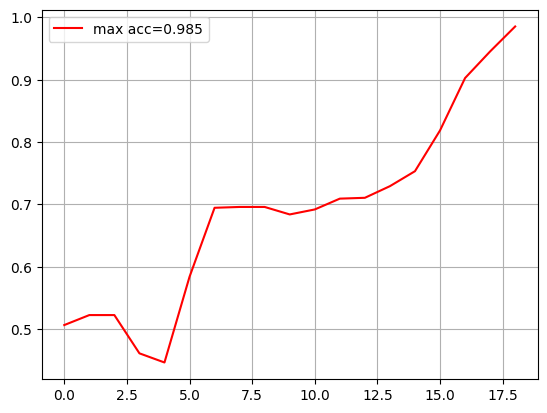

In [15]:
# история изменения значений погрешности модели
plt.plot(result.history['accuracy'],label='max acc=%.3f'%(max(result.history['accuracy'])),c='r')
plt.grid()
plt.legend()

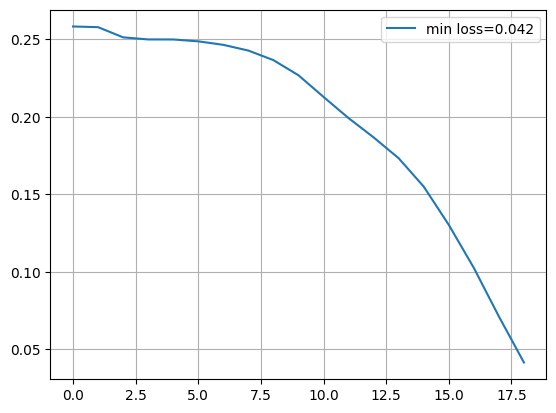

In [16]:
# история изменения значений ф-ции потери
plt.plot(result.history['loss'],label='min loss=%.3f'%(min(result.history['loss'])))
plt.grid()
plt.legend()

## тестируем модель

In [17]:
s = model.predict( tf.cast(X_test,tf.float32) )[:,1]

y_test_label = np.argmax(y_test,axis=1)

24/24 [==============================] - 0s 646us/step


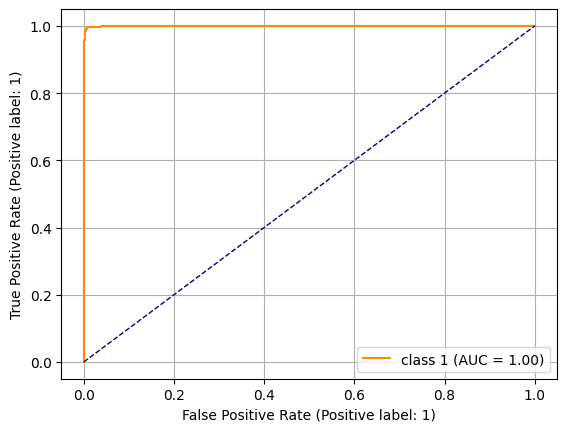

In [18]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions( y_test_label, s, name="class 1", color="darkorange", )
plt.plot([0,1],[0,1], color='navy', lw=1, linestyle='--')
plt.grid()

In [19]:
# определяем оптимальный порог скора 
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve( y_test_label, s )

#  максимальное количество True Positive при минимальном количестве False Positive
optimal_threshold = thresholds[ np.argmax( np.abs(tpr-fpr) )  ]
display(optimal_threshold)

0.45625937

In [20]:
# применяем оптимальный порог скора, предсказываем класс объектов
y_pred = (s>optimal_threshold).astype(int)

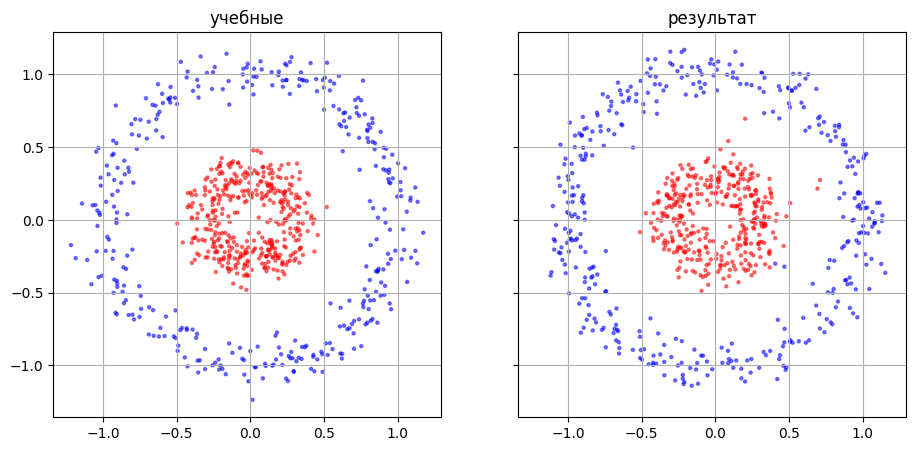

In [21]:
fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(11,5),)

ax0.set_title('учебные')
ax0.scatter( x=X_train[:,0], y=X_train[:,1], c=out2color(y_train), s=5, alpha=0.5 )
ax0.grid()

ax1.set_title('результат')
ax1.scatter( x=X_test[:,0], y=X_test[:,1], c=label2color(y_pred), s=5, alpha=0.5 )
ax1.grid()
  
plt.show()

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test_label,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       392
           1       0.99      0.99      0.99       358

    accuracy                           0.99       750
   macro avg       0.99      0.99      0.99       750
weighted avg       0.99      0.99      0.99       750



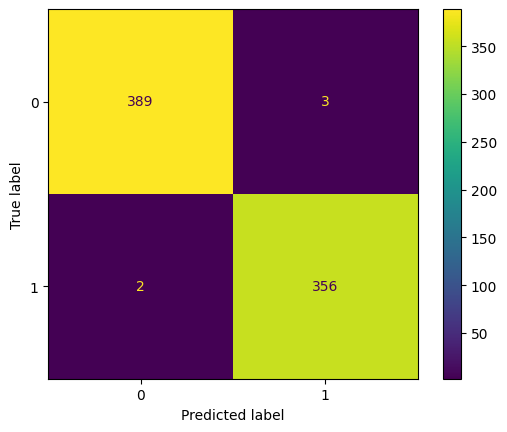

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test_label, y_pred), 
    #display_labels=classes
).plot()

### карта скоров

7813/7813 [==============================] - 4s 513us/step


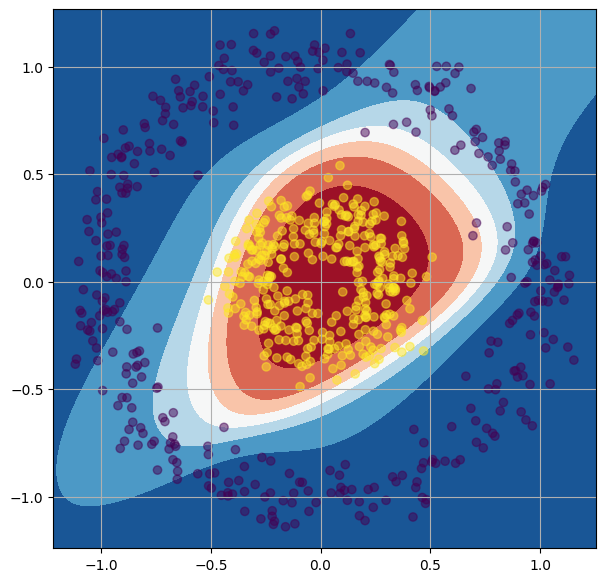

In [24]:
# строим сетку и определяем значения скора классификатора во всех узлах

n=500 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-.1, X_test[:,0].max()+.1, n), 
    np.linspace( X_test[:,1].min()-.1, X_test[:,1].max()+.1, n)
) # узлы сетки

xy = np.vstack([xx.flatten(),yy.flatten() ]).T # разворачиваем сетку 

s = model.predict( tf.cast(xy,tf.float32) )[:,1]

plt.figure(figsize=(7,7))
plt.contourf(xx, yy, (1.-s).reshape(n,n), cmap=plt.cm.RdBu)
plt.scatter( x=X_test[:,0], y=X_test[:,1], c=y_test_label, alpha=.5 )
plt.grid()